In [84]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from joblib import load, dump

# импортируем модели
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# игнорировать предупреждения
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [61]:
# загружаем данные в датафреймы пандас
train_df = pd.read_csv('salary_train.csv', index_col=0)
predict_df = pd.read_csv('salary_predict.csv', index_col=0)
print(train_df.shape)
train_df.head()

(9000, 7)


,algebra,programming,data science,robotics,economics,job,salary
Id,,,,,,,
0,87,62,86,61,90,junior developer,140000
1,76,84,76,80,79,data scientist,780000
2,56,55,99,82,98,developer,210000
3,99,66,65,84,58,economist,420000
4,73,87,56,84,73,data scientist,760000


In [62]:
# смотрим типы данных нашего датасета и проверяем на пропуски
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 0 to 8999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   algebra       9000 non-null   int64 
 1   programming   9000 non-null   int64 
 2   data science  9000 non-null   int64 
 3   robotics      9000 non-null   int64 
 4   economics     9000 non-null   int64 
 5   job           9000 non-null   object
 6   salary        9000 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 562.5+ KB


In [75]:
# статистика по каждому столбцу
train_df.describe()

,algebra,programming,data science,robotics,economics,salary
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9.000000e+03
mean,74.485556,74.500111,74.349889,74.445444,74.620556,5.197633e+05
std,14.470835,14.489513,14.340312,14.362890,14.402834,2.805051e+05
min,50.000000,50.000000,50.000000,50.000000,50.000000,9.000000e+04
25%,62.000000,62.000000,62.000000,62.000000,62.000000,3.000000e+05
50%,74.000000,74.000000,75.000000,74.000000,75.000000,4.600000e+05
75%,87.000000,87.000000,87.000000,87.000000,87.000000,7.600000e+05
max,99.000000,99.000000,99.000000,99.000000,99.000000,1.350000e+06


Histogram of algebra


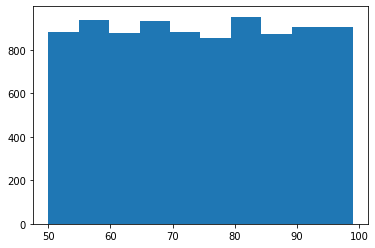

Histogram of programming


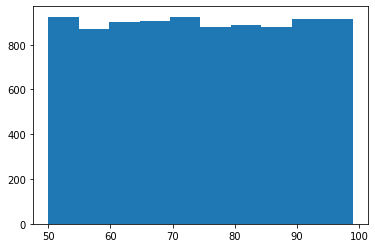

Histogram of data science


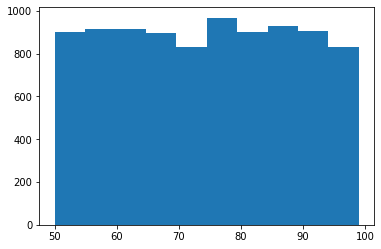

Histogram of robotics


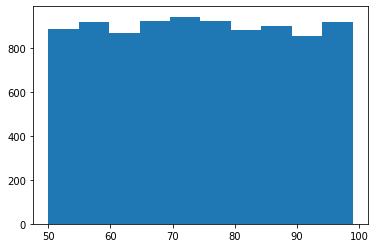

Histogram of economics


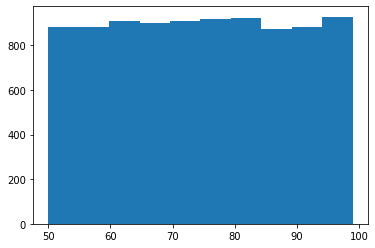

Histogram of salary


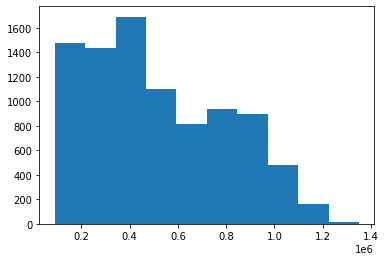

In [76]:
# построим гистограммы для результатов теста
hist_ls = train_df.select_dtypes(include='int64').columns
for feature in hist_ls:
    print('Histogram of', feature)
    plt.hist(train_df[feature])
    plt.show()

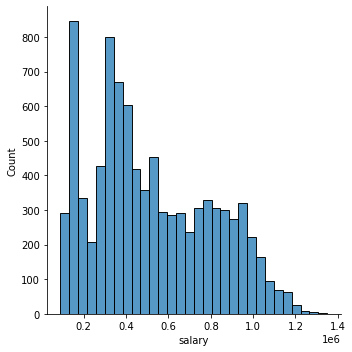

In [83]:
# также построим распределение для таргета
sns.displot(train_df['salary'], bins = 30)
plt.show()

In [66]:
# посмотрим какие профессии имеют наибольшую зарплату
train_df.loc[train_df['salary'] > 1e6, 'job'].value_counts()

robotics engineer    427
data scientist        48
Name: job, dtype: int64

In [67]:
# сделаем one-hot encoding для столбца job и разделим датасет на матрицу объекты-признаки и вектор ответов
def transform(df):
    X, y = df.drop('salary', axis=1), df['salary']
    X = pd.get_dummies(X)
    return X, y

X, y = transform(train_df)
X_predict, y_predict = transform(predict_df)
X

,algebra,programming,data science,robotics,economics,job_data scientist,job_developer,job_economist,job_junior developer,job_robotics engineer,job_senior developer
Id,,,,,,,,,,,
0,87,62,86,61,90,0,0,0,1,0,0
1,76,84,76,80,79,1,0,0,0,0,0
2,56,55,99,82,98,0,1,0,0,0,0
3,99,66,65,84,58,0,0,1,0,0,0
4,73,87,56,84,73,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8995,58,85,68,62,97,0,0,0,0,0,1
8996,92,58,99,77,81,0,0,0,0,1,0
8997,92,54,81,63,74,0,1,0,0,0,0


In [69]:
# разбиваем датасет для обучения на тренировочный и валидационный
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)
X_train

,algebra,programming,data science,robotics,economics,job_data scientist,job_developer,job_economist,job_junior developer,job_robotics engineer,job_senior developer
Id,,,,,,,,,,,
7607,88,93,82,77,99,0,0,0,0,1,0
1522,93,68,80,71,71,0,0,1,0,0,0
2454,53,63,72,73,77,0,0,0,0,0,1
3990,62,54,52,73,56,0,1,0,0,0,0
735,87,95,60,76,51,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
350,63,92,80,71,90,0,0,0,0,1,0
79,98,66,62,61,64,0,1,0,0,0,0
8039,70,96,76,58,93,0,1,0,0,0,0


Проверяем выбранные модели: линейную регрессию без регуляриции и с (L1, L2, ElasticNet), kNN, CART, CaBoost и LGBM. Создаем пайплайн с тремя шагами: масштабирование данных через StandardScaler, трансформация выборки через PolynomialFeatures со степенью два и сама модель. На ответы каждой модели выводим соответствующие R2 и среднюю квадратическую ошибку по валидационному датасету.

In [74]:
models = [('LR',    LinearRegression()),
          ('EN',    ElasticNet()),
          ('Lasso', Lasso(tol=0.01)),
          ('Ridge', Ridge(tol=0.01)),
          ('KNN',   KNeighborsRegressor()),
          ('CART',  DecisionTreeRegressor()),
          ('CB',    CatBoostRegressor(eval_metric="RMSE", logging_level='Silent')),
          ('LGMB',  LGBMRegressor())]

pipelines = {}

for name, model in models:
    pipelines[name] = Pipeline([('scale', StandardScaler()),
                                ('polyf', PolynomialFeatures(include_bias=False)),
                                ('model', model)])
    pipe = pipelines[name]
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(y_test, y_hat)))
    r2 = r2_score(y_test, y_hat)
    print(name, ': testing performance')
    print('RMSE: {:.2f}'.format(rmse))
    print('R2: {:.4f}\n'.format(r2))

LR : testing performance
RMSE: 50317.28
R2: 0.9691

EN : testing performance
RMSE: 59133.85
R2: 0.9573

Lasso : testing performance
RMSE: 50351.36
R2: 0.9691

Ridge : testing performance
RMSE: 50351.47
R2: 0.9691

KNN : testing performance
RMSE: 54785.52
R2: 0.9634

CART : testing performance
RMSE: 75894.66
R2: 0.9297

CB : testing performance
RMSE: 52254.54
R2: 0.9667

LGMB : testing performance
RMSE: 53209.74
R2: 0.9654



In [32]:
pipelines

{'LR': Pipeline(steps=[('scale', StandardScaler()),
                 ('polyf', PolynomialFeatures(include_bias=False)),
                 ('model', LinearRegression())]),
 'EN': Pipeline(steps=[('scale', StandardScaler()),
                 ('polyf', PolynomialFeatures(include_bias=False)),
                 ('model', ElasticNet())]),
 'Lasso': Pipeline(steps=[('scale', StandardScaler()),
                 ('polyf', PolynomialFeatures(include_bias=False)),
                 ('model', Lasso(tol=0.01))]),
 'KNN': Pipeline(steps=[('scale', StandardScaler()),
                 ('polyf', PolynomialFeatures(include_bias=False)),
                 ('model', KNeighborsRegressor())]),
 'CART': Pipeline(steps=[('scale', StandardScaler()),
                 ('polyf', PolynomialFeatures(include_bias=False)),
                 ('model', DecisionTreeRegressor())]),
 'CB': Pipeline(steps=[('scale', StandardScaler()),
                 ('polyf', PolynomialFeatures(include_bias=False)),
                 ('model'

Как оказалось, линейная регрессия без регуляризации выдает наилучшую метрику на тренировочных данных. Воспользуемся им же для предсказания тестового датасета. Все значения больше $10^6$ приравниваем $10^6$ и округляем ответы до ближайшего целого числа чтобы соответствовало формату Kaggle.

In [89]:
predictions = pipelines['LR'].predict(X_predict)
vfunc = np.vectorize(lambda t: min(int(round(t)), 1000000))
predictions = vfunc(predictions)
predictions[:5]

array([ 727424,  557312,  331520, 1000000,  140032])

In [90]:
# удаляем все столбцы в X_test и для каждого Id пишем предсказанную зарплату
X_predict = X_predict.drop(X_predict.columns, axis=1)
X_predict.insert(0, "salary", predictions, True)
X_predict

,salary
Id,
9000,727424
9001,557312
9002,331520
9003,1000000
9004,140032
...,...
9995,190464
9996,383744
9997,312832


In [91]:
# сохраняем ответ в виде файла final_predict.csv и загружаем модели в models.joblib
X_predict.to_csv('final_predict.csv')
dump(pipelines, 'models.joblib')

['models.joblib']